In [44]:
#======Libraries======
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

In [45]:
#======Function Definitions======
def dot_aligned(seq): #Aligns floating point values in a list to the decimal point
    snums = [str(n) for n in seq]
    dots = [s.find('.') for s in snums]
    m = max(dots)
    return [' '*(m - d) + s for s, d in zip(snums, dots)]

In [46]:
#======Initialization======
#Sets a random seed for NumPy and PyTorch
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#Sets precision to 20 digits
torch.set_printoptions(precision = 20)
np.set_printoptions(precision = 20)

#Sets device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

First, we will use PyTorch to predict the temperature in celsius given the temperature in fahrenheit.

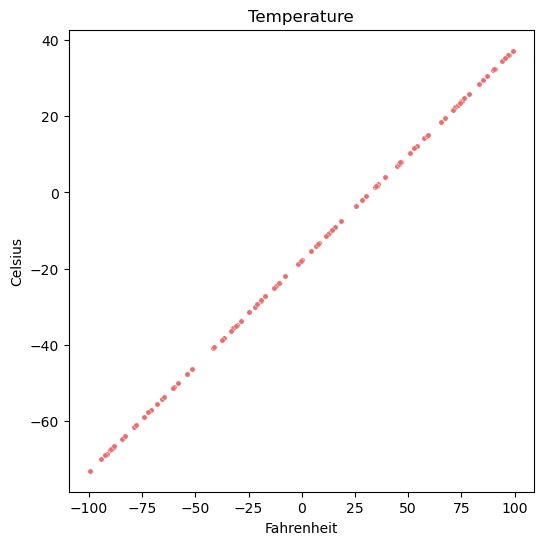

In [47]:
#======Data Loading======
df = pd.read_csv("data_fahrenheit_celsius.csv") #Loads data
df.dropna(axis = 0, how = 'any', inplace = True) #Drops invalid rows
# df.head()

#Visualizes the data
plt.figure(figsize = (6, 6), dpi = 100)
plt.title("Temperature")
sns.scatterplot(data = df, x = "Fahrenheit", y = "Celsius", s = 15, color = "#E67070")
plt.show()

In [48]:
#======Data Cleaning======
#Defines the features and labels
features = df["Fahrenheit"].values.reshape(-1, 1)
labels = df["Celsius"].values.reshape(-1, 1)

#labels = StandardScaler().fit_transform(labels)

#Splits the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2)

#scaler = RobustScaler().fit(x_train)

#x_train = scaler.transform(x_train)
#x_test = scaler.transform(x_test)

x_test_df = pd.DataFrame(x_test, columns=["Fahrenheit"])
y_test_df = pd.DataFrame(y_test, columns=["Celsius"])

# Concatenate x_test and y_test horizontally
test_df = pd.concat([x_test_df, y_test_df], axis=1)

In [49]:
#======Training======
#Hypervariables
lr = 1e-4 #Learning rate
n_epochs = 30000 #Number of epochs

#Creates a model and sends it to the device
model = nn.Sequential(nn.Linear(1, 1)).to(device)

#Defines a MSE loss function (ridge or L2 norm)
loss_fn = nn.MSELoss()

#Defines a stochastic gradient descent (SGD) optimizer to update the parameters
optimizer = optim.SGD(model.parameters(), lr)

#Sets the model to training mode
model.train()

#Sends the training set to PyTorch
x_train = torch.from_numpy(x_train).float().to(device)
y_train = torch.from_numpy(y_train).float().to(device)

#Loops through the number of epochs
for epoch in range(n_epochs):
    #Computes the predicted output
    yhat = model(x_train)

    #Computes the loss using MSE
    loss = loss_fn(yhat, y_train)
    loss.backward()

    #Punishes the model based off the training set
    optimizer.step()
    optimizer.zero_grad()

#Prints the weight and bias after training
states = dot_aligned(["{:.20f}".format(value.cpu().detach().numpy().item()) for value in model.state_dict().values()])
print(f"Weight:\t{states[0]}")  #Should be   0.5556
print(f"Bias:\t{states[1]}")    #Should be -17.7778

Weight:	  0.55551064014434814453
Bias:	-17.73061943054199218750


Testing set statistics
Median:	0.04730035631347729
Mean:	0.04691666523005429
STD:	0.0026679275935586107



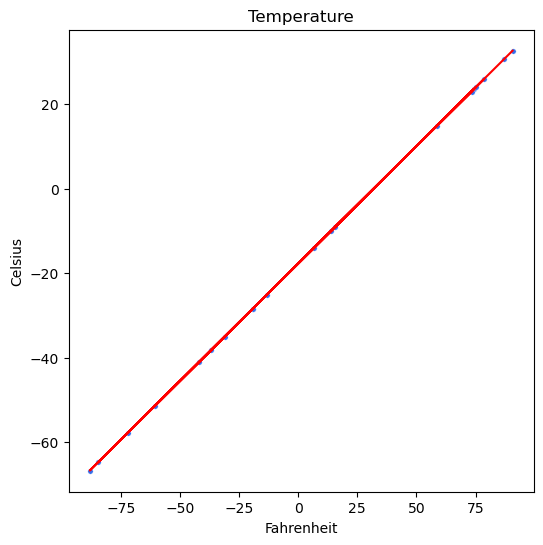

New set statistics
Median:	0.047337362971667574
Mean:	0.0472173843321181
STD:	0.0024157131777764657


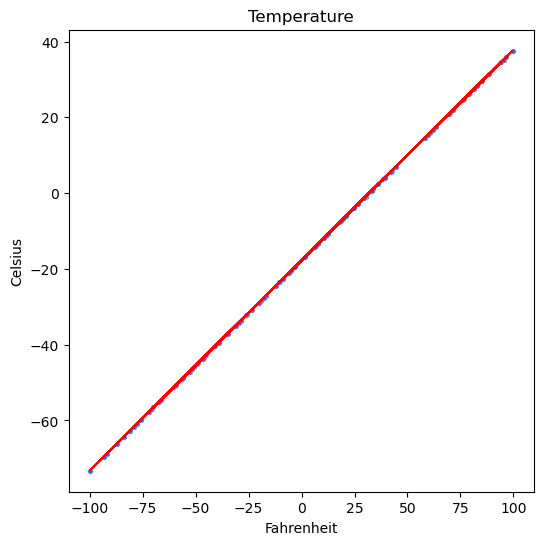

In [50]:
#======Testing======
#Sets the model to evaluation mode
model.eval()

#Sends the validation set to PyTorch
x_test = torch.from_numpy(x_test).float().to(device)

#Computes the predicted output
yhat = model(x_test)

#Gets the predicted output and compares it to the actual output
y_predicted = yhat.cpu().detach().numpy()
comparison = abs(y_predicted - y_test).flatten()

#Prints statistics
print("Testing set statistics")
print(f"Median:\t{np.median(comparison)}")
print(f"Mean:\t{np.mean(comparison)}")
print(f"STD:\t{np.std(comparison)}", end = "\n\n")

#Visualizes the data
plt.figure(figsize = (6, 6), dpi = 100)
plt.title("Temperature")
sns.scatterplot(data = test_df, x = "Fahrenheit", y = "Celsius", s = 15, color = "#346EEB")
plt.plot(test_df["Fahrenheit"], y_predicted, "red")
plt.show()

# %%
#Evaluates numbers outside of the training set
x_new = np.random.uniform(-100, 100, (100, 1))
y_new = (x_new - 32) / 1.8
x_new_df = pd.DataFrame(x_new, columns=["Fahrenheit"])
y_new_df = pd.DataFrame(y_new, columns=["Celsius"])

#Sends the new set to PyTorch
x_new = torch.from_numpy(x_new).float().to(device)
test_df2 = pd.concat([x_new_df, y_new_df], axis=1)

#Computes the predicted output
yhat = model(x_new)

#Gets the predicted output and compares it to the actual output
y_predicted = yhat.cpu().detach().numpy()
comparison = abs(y_predicted - y_new).flatten()

#Prints statistics
print("New set statistics")
print(f"Median:\t{np.median(comparison)}")
print(f"Mean:\t{np.mean(comparison)}")
print(f"STD:\t{np.std(comparison)}")

#Plots lines
#Visualizes the data
plt.figure(figsize = (6, 6), dpi = 100)
plt.title("Temperature")
sns.scatterplot(data = test_df2, x = "Fahrenheit", y = "Celsius", s = 15, color = "#346EEB")
plt.plot(test_df2["Fahrenheit"], y_predicted, "red")
plt.show()